# **Importing & Downloading Dataset.**

In [3]:
import zipfile

# Define the path to the ZIP file and the destination directory
zip_file_path = 'fake-news.zip'
destination_directory = '/Users/rishabhmathur/Documents/Development/Machine Learning/Projects/Fake News Detection'

# Unzip the dataset into the specified directory (the home directory)
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(destination_directory)

# **Installing necessary dependencies.**

In [4]:
%pip install transformers nltk pandas numpy matplotlib seaborn wordcloud


[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


# **Importing necessary libraries.**

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

In [6]:
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [7]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rishabhmathur/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/rishabhmathur/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# **Loading Dataset**

In [8]:
# Loading the dataset.
news_d = pd.read_csv("/Users/rishabhmathur/Documents/Development/Machine Learning/Projects/Fake News Detection/train.csv")
print("Shape of news:", news_d.shape)
print("Columns in data: ", news_d.columns)

Shape of news: (20800, 5)
Columns in data:  Index(['id', 'title', 'author', 'text', 'label'], dtype='object')


In [9]:
# To familiarize the dataset.
news_d.head(10)

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1
5,5,Jackie Mason: Hollywood Would Love Trump if He...,Daniel Nussbaum,"In these trying times, Jackie Mason is the Voi...",0
6,6,Life: Life Of Luxury: Elton John’s 6 Favorite ...,NaN,Ever wonder how Britain’s most iconic pop pian...,1
7,7,Benoît Hamon Wins French Socialist Party’s Pre...,Alissa J. Rubin,"PARIS — France chose an idealistic, traditi...",0
8,8,Excerpts From a Draft Script for Donald Trump’...,NaN,Donald J. Trump is scheduled to make a highly ...,0
9,9,"A Back-Channel Plan for Ukraine and Russia, Co...",Megan Twohey and Scott Shane,A week before Michael T. Flynn resigned as nat...,0


In [10]:
# Calculates the statistics of "TEXT" column.
txt_length = news_d.text.str.split().str.len()
txt_length.describe()

count    20761.000000
mean       760.308126
std        869.525988
min          0.000000
25%        269.000000
50%        556.000000
75%       1052.000000
max      24234.000000
Name: text, dtype: float64

In [11]:
# Calculate statistics of "TITLE" column.
title_length = news_d.title.str.split().str.len()
title_length.describe()

count    20242.000000
mean        12.420709
std          4.098735
min          1.000000
25%         10.000000
50%         13.000000
75%         15.000000
max         72.000000
Name: title, dtype: float64

The statistics for the training and testing sets are as follows:

*   The **text** attribute has a higher word count with an average of 760 words and *75% having more than 1000 words*.
*   The **title** attribute is a short statement with an average of 12 words, and *75% of them are around 15 words*.

Our experiment would be with both text and title together.



1: Unreliable
0: Reliable

Distribution of data
label
1    10413
0    10387
Name: count, dtype: int64


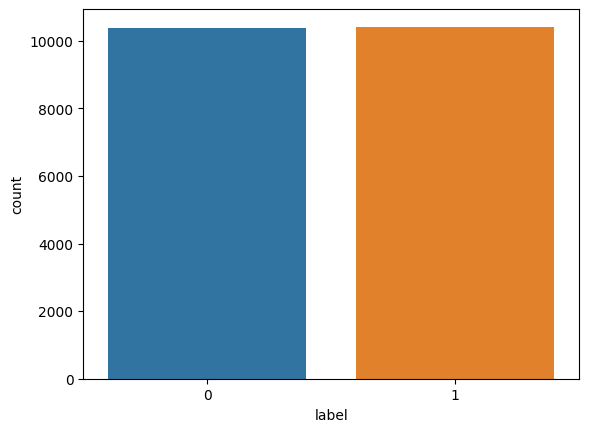

In [12]:
sns.countplot(x="label", data=news_d)
print("1: Unreliable")
print("0: Reliable\n")

print("Distribution of data")
print(news_d.label.value_counts())

In [13]:
# Print the percentage distribution of labels in our dataset.
print(round(news_d.label.value_counts(normalize=True),2)*100)

label
1    50.0
0    50.0
Name: proportion, dtype: float64


# **Data Preprocessing**

*   Drop unused rows and columns.
*   Perform null value imputation.
*   Remove special characters.
*   Remove stop words.





In [14]:
# Constants that are used to sanitize the datasets

column_n = ['id', 'title', 'author', 'text', 'label']
remove_c = ['id', 'author']

categorical_features = []

target_c = ['label']
text_f = ['title', 'text']

In [15]:
import nltk
from nltk.corpus import stopwords
import re
from nltk.stem.porter import PorterStemmer
from collections import Counter

ps = PorterStemmer()
wnl = nltk.stem.WordNetLemmatizer()

stop_words = stopwords.words('english')
stopwords_dict = Counter(stop_words)

# Removed unused clumns
def remove_unused_c(df,column_n=remove_c):
    df = df.drop(column_n,axis=1)
    return df

# Impute null values with None
def null_process(feature_df):
    for col in text_f:
        feature_df.loc[feature_df[col].isnull(), col] = "None"
    return feature_df

def clean_dataset(df):
    # remove unused column
    df = remove_unused_c(df)
    #impute null values
    df = null_process(df)
    return df

# Cleaning text from unused characters
def clean_text(text):
    text = str(text).replace(r'http[\w:/\.]+', ' ')  # removing urls
    text = str(text).replace(r'[^\.\w\s]', ' ')  # remove everything but characters and punctuation
    text = str(text).replace('[^a-zA-Z]', ' ')
    text = str(text).replace(r'\s\s+', ' ')
    text = text.lower().strip()
    #text = ' '.join(text)
    return text

## Nltk Preprocessing include:
# Stop words, Stemming and Lemmetization
# For our project we use only Stop word removal
def nltk_preprocess(text):
    text = clean_text(text)
    wordlist = re.sub(r'[^\w\s]', '', text).split()
    #text = ' '.join([word for word in wordlist if word not in stopwords_dict])
    #text = [ps.stem(word) for word in wordlist if not word in stopwords_dict]
    text = ' '.join([wnl.lemmatize(word) for word in wordlist if word not in stopwords_dict])
    return text


In [16]:
df = clean_dataset(news_d)

# Applying preprocessing on the "text" and "title" column of dataframe.
df["text"] = df.text.apply(nltk_preprocess)
df["title"] = df.title.apply(nltk_preprocess)

# Dataset after cleaning and preprocessing step.
df.head(10)

,title,text,label
0,house dem aide didnt even see comeys letter ja...,house dem aide didnt even see comeys letter ja...,1
1,flynn hillary clinton big woman campus breitbart,ever get feeling life circle roundabout rather...,0
2,truth might get fired,truth might get fired october 29 2016 tension ...,1
3,15 civilian killed single u airstrike identified,video 15 civilian killed single u airstrike id...,1
4,iranian woman jailed fictional unpublished sto...,print iranian woman sentenced six year prison ...,1
5,jackie mason hollywood would love trump bombed...,trying time jackie mason voice reason week exc...,0
6,life life luxury elton john 6 favorite shark p...,ever wonder britain iconic pop pianist get lon...,1
7,benoît hamon win french socialist party presid...,paris france chose idealistic traditional cand...,0
8,excerpt draft script donald trump qampa black ...,donald j trump scheduled make highly anticipat...,0
9,backchannel plan ukraine russia courtesy trump...,week michael flynn resigned national security ...,0


# **EDA**


*   Univariate Analysis
*   Bivariate Analysis



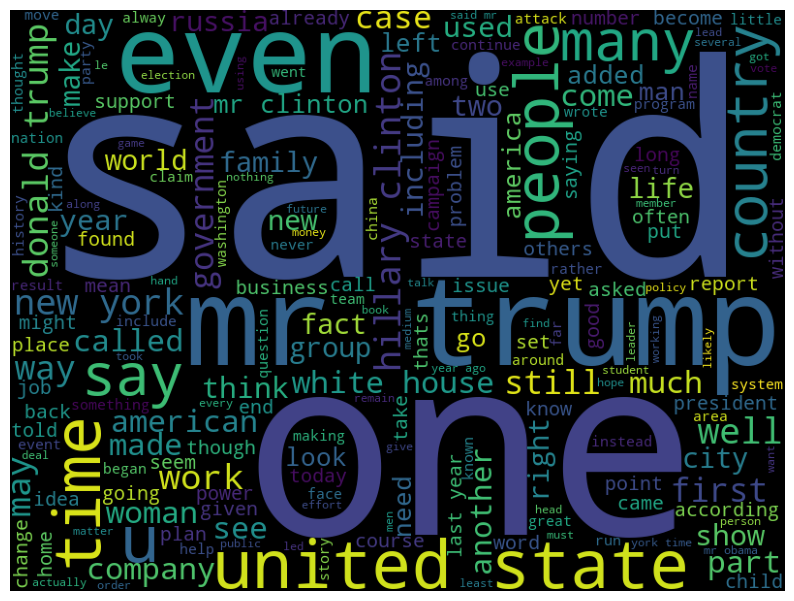

In [17]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

wordcloud = WordCloud( background_color='black', width=800, height=600)

text_cloud = wordcloud.generate(' '.join(df['text']))

plt.figure(figsize=(10,20))
plt.imshow(text_cloud)
plt.axis('off')
plt.show()

Word CLoud for the reliable news only:

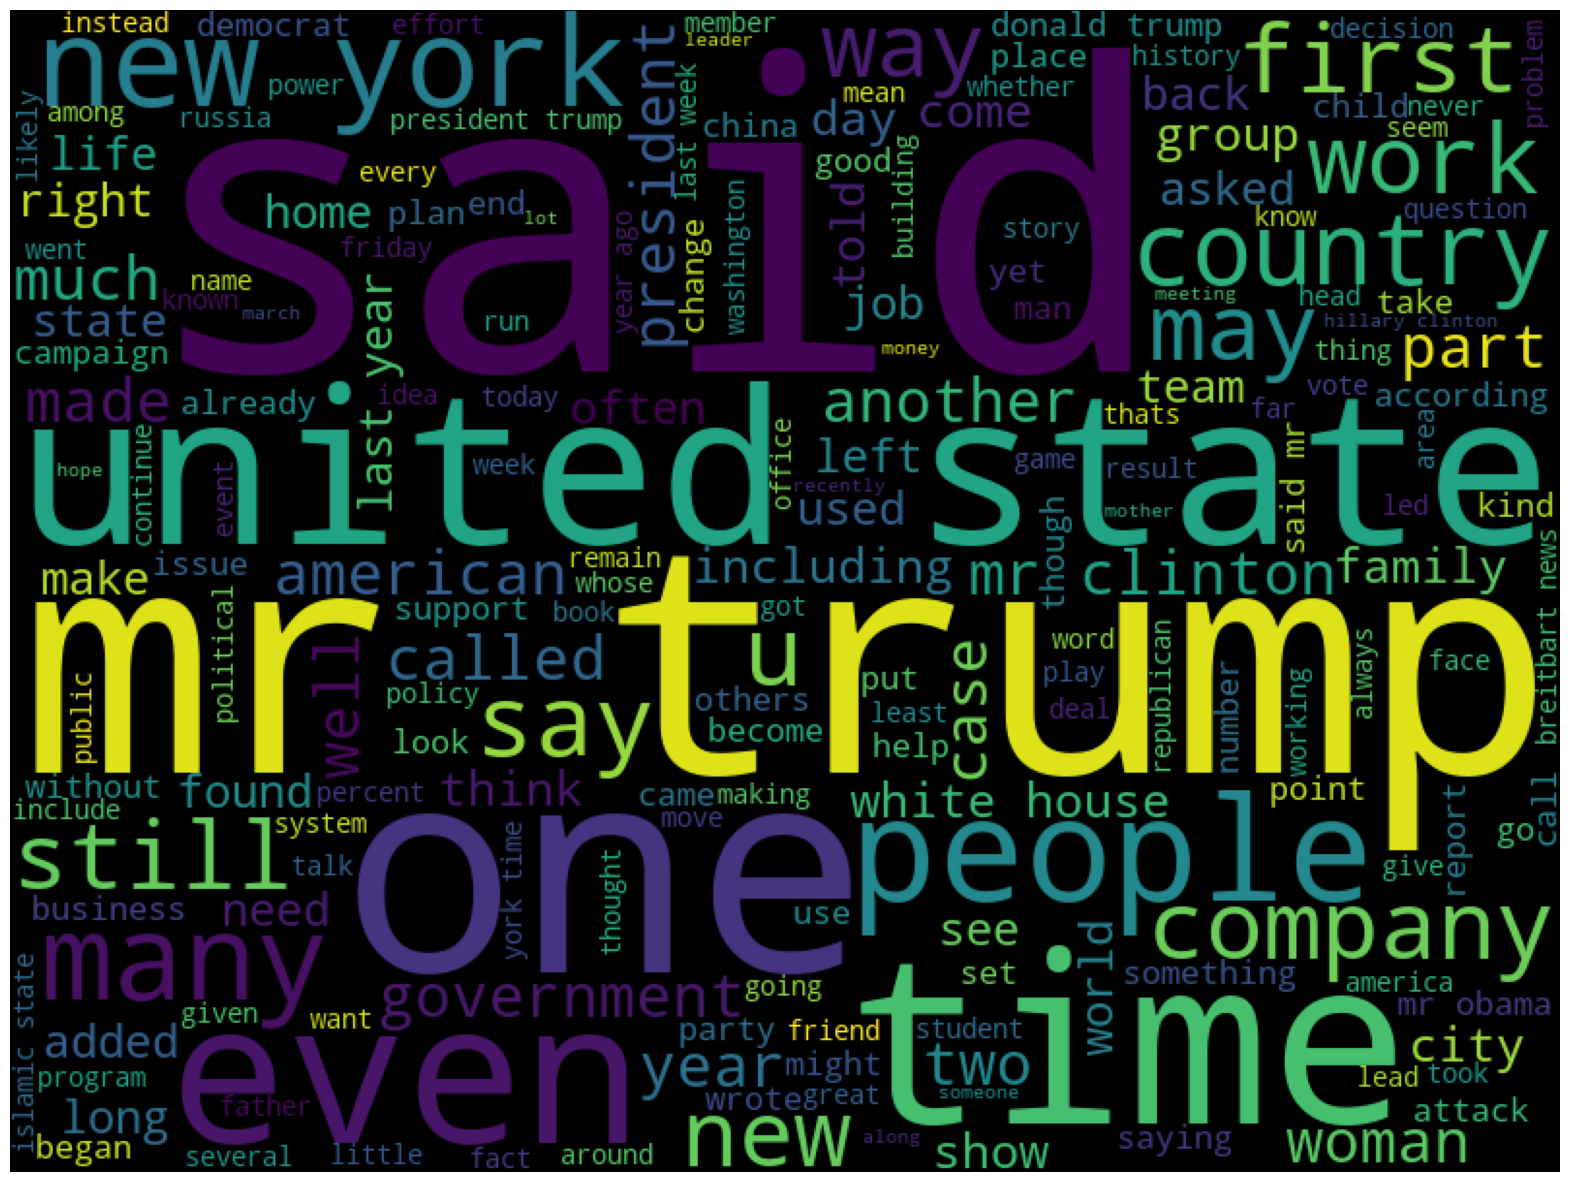

In [18]:
true_n = ' '.join(df[df['label'] == 0]['text'])
wc = wordcloud.generate(true_n)
plt.figure(figsize=(20,30))
plt.imshow(wc)
plt.axis('off')
plt.show()

Word Cloud for the unreliable (**Fake news**) news:

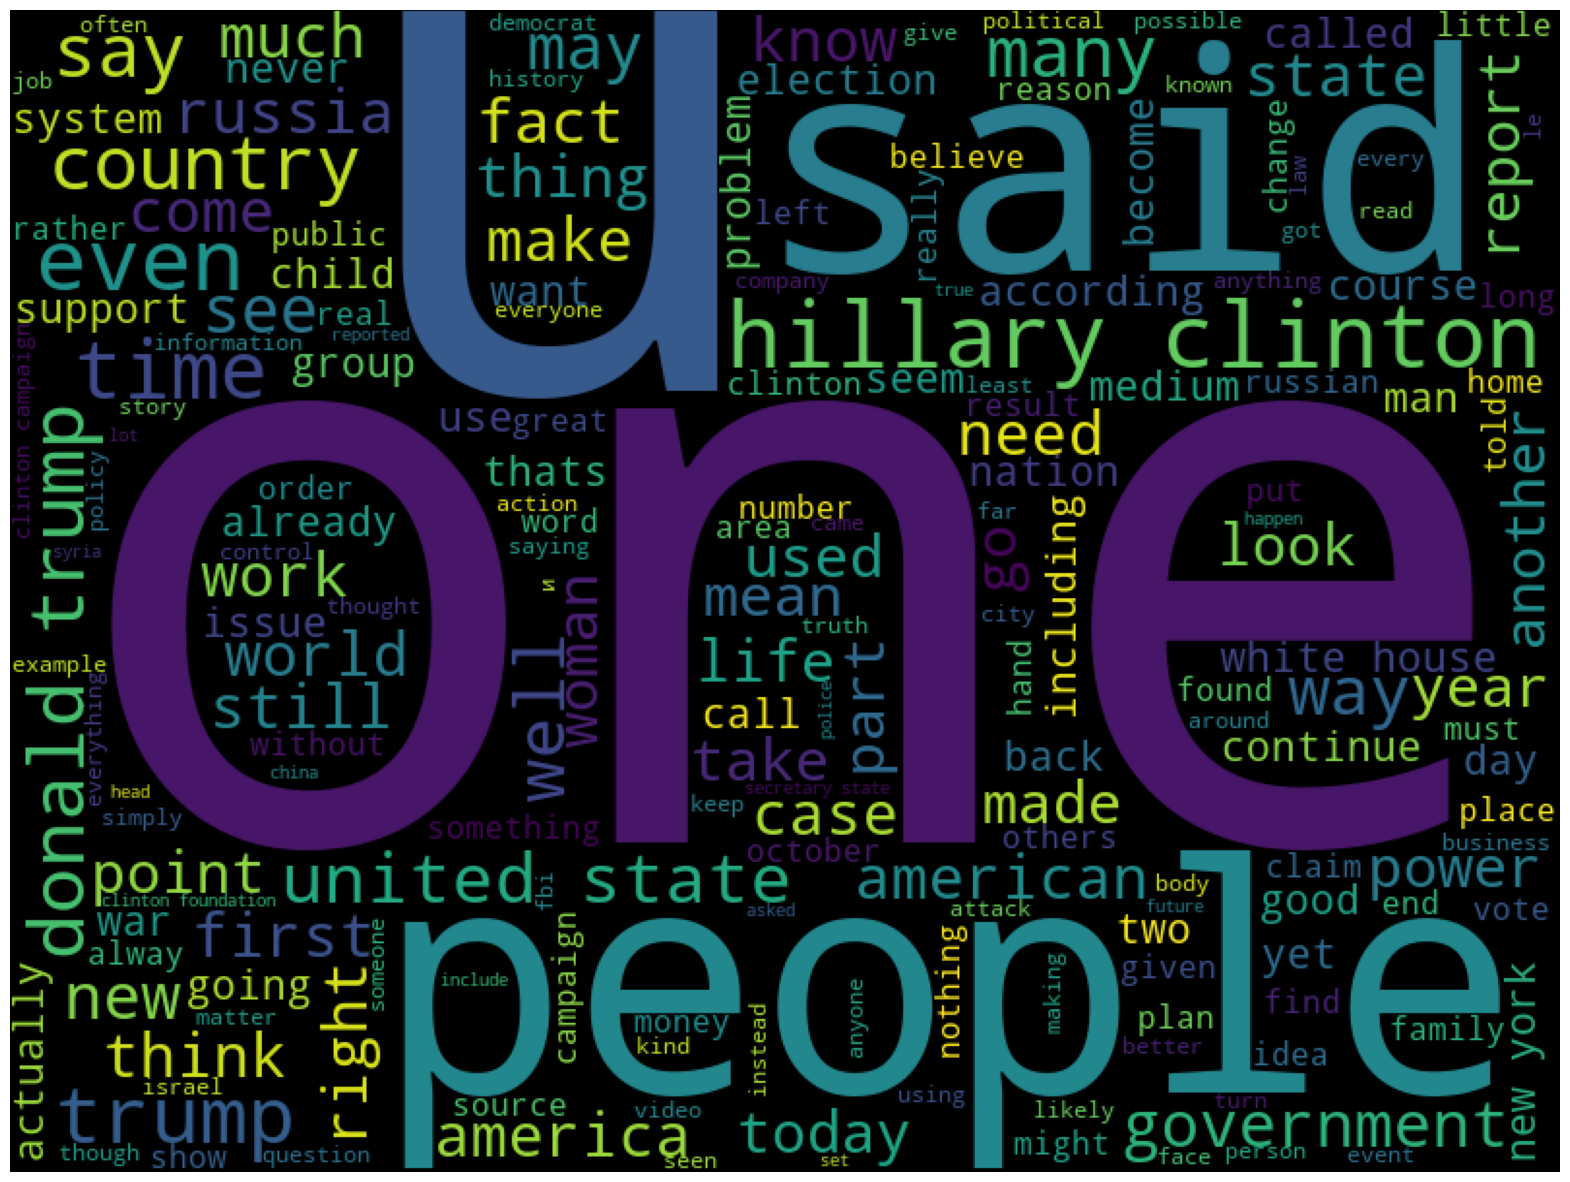

In [19]:
fake_n = ' '.join(df[df['label']==1]['text'])
wc= wordcloud.generate(fake_n)
plt.figure(figsize=(20,30))
plt.imshow(wc)
plt.axis('off')
plt.show()

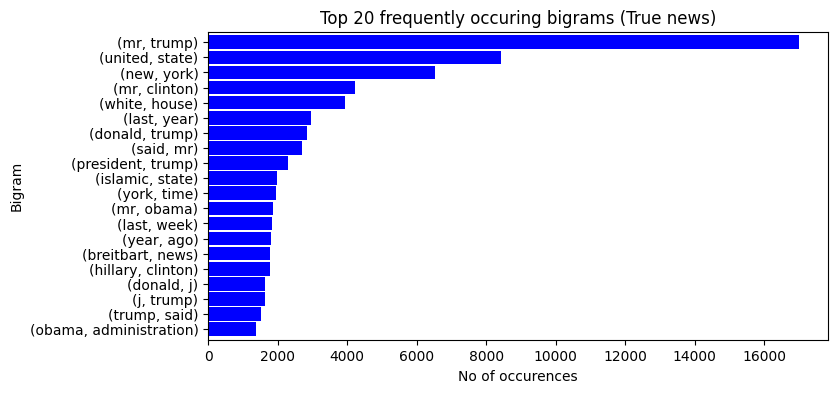

In [20]:
# The most common bi-grams of true news.

def plotTopNgrams(corpus, title, xlabel, ylabel, n=2):
  true_b = pd.Series(nltk.ngrams(corpus.split(), n)).value_counts()[:20]
  true_b.sort_values().plot.barh(color = 'blue', width=0.9, figsize=(8, 4))
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.show()

plotTopNgrams(true_n, "Top 20 frequently occuring bigrams (True news)", "No of occurences", "Bigram", n=2)

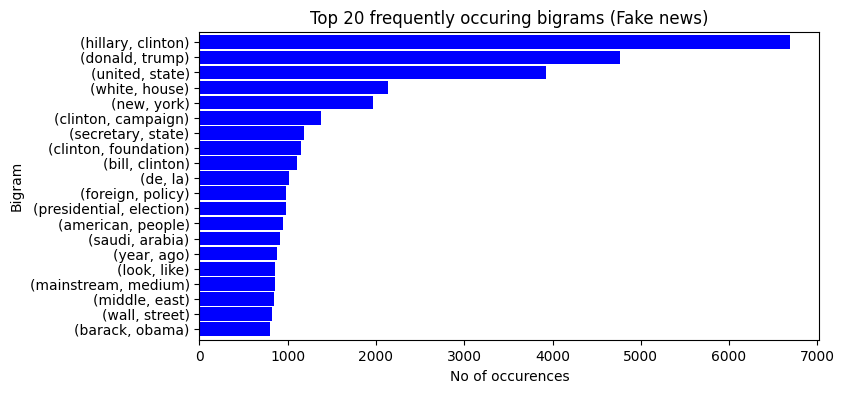

In [21]:
# The most common bigrams on fake news.
plotTopNgrams(fake_n, "Top 20 frequently occuring bigrams (Fake news)", "No of occurences", "Bigram", n=2)

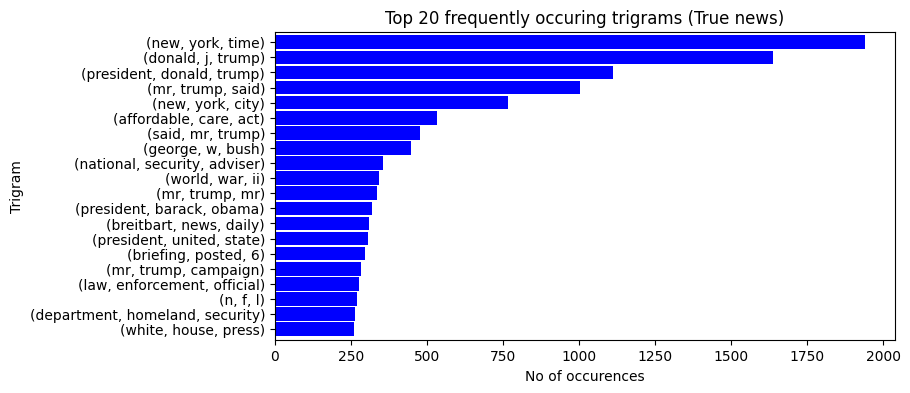

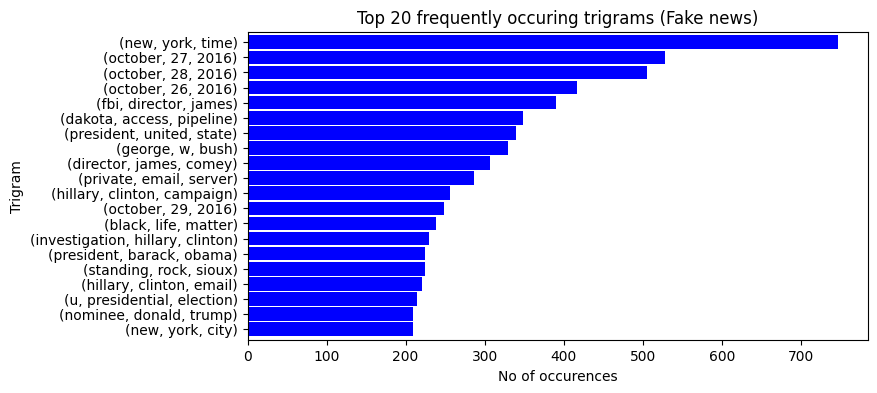

In [22]:
# The most frequent trigrams:
#   1. True news
#   2. Fake news

plotTopNgrams(true_n, "Top 20 frequently occuring trigrams (True news)", "No of occurences", "Trigram", n=3)
plotTopNgrams(fake_n, "Top 20 frequently occuring trigrams (Fake news)", "No of occurences", "Trigram", n=3)

# **Building a Classifier by Fine-tuning BERT**

In [23]:
%pip install transformers


[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [24]:
import torch
from transformers import is_tf_available, is_torch_available, is_torch_tpu_available
from transformers import BertTokenizerFast, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
import numpy as np
from sklearn.model_selection import train_test_split

import random

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**We want to make our results reproducible even if we restart our environment:**



In [25]:
def setSeed(seed: int):
  random.seed(seed)
  np.random.seed(seed)

  if is_torch_available():
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

  if is_tf_available():
    import tensorflow as tf
    tf.random.set_seed(seed)

setSeed(1)

In [26]:
model_name = "bert-base-uncased"
max_length = 512

In [27]:
# Loading the tokenizer
tokenizer = BertTokenizerFast.from_pretrained(model_name, do_lower_case = True)

**1. Data preparation**

In [28]:
newsdf = news_d[news_d['text'].notna()]
newsdf = newsdf[newsdf['author'].notna()]
newsdf = newsdf[newsdf['title'].notna()]

In [29]:
def prepareData(df, test_size=0.2, include_title=True, include_author=True):
  texts = []
  labels = []

  for i in range(len(df)):
    text = df["text"].iloc[i]
    label = df["label"].iloc[i]

    if(include_title):
      text = df["title"].iloc[i] + "-" + text

    if(include_author):
      text = df["author"].iloc[i] + ":" + text

    if(text and label in [0,1]):
      texts.append(text)
      labels.append(label)

  return train_test_split(texts, labels, test_size=test_size)

train_texts, test_texts, train_labels, test_labels = prepareData(newsdf)

In [30]:
print(len(train_texts), len(train_labels))
print(len(test_texts), len(test_labels))

14628 14628
3657 3657


**2. Tokenizing the dataset**

In [31]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=max_length)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=max_length)

In [32]:
class NewsGroupsDataset(torch.utils.data.Dataset):
  def __init__(self, encodings, labels):
    self.encodings = encodings
    self.labels = labels

  def __getitem__(self, idx):
    item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
    item["labels"] = torch.tensor(self.labels[idx])
    return item

  def __len__(self):
    return len(self.labels)

train_dataset = NewsGroupsDataset(train_encodings, train_labels)
test_dataset = NewsGroupsDataset(test_encodings, test_labels)

**3. Loading and fine tuning Model**

In [33]:
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [34]:
%pip install accelerate -U
%pip install transformers[torch]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)

[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
zsh:1: no matches found: transformers[torch]
Note: you may need to restart the kernel to use updated packages.


In [35]:
# Now we would be training the model.

from sklearn.metrics import accuracy_score

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  acc = accuracy_score(labels, preds)

  return{
      'accuracy': acc,
  }

training_args = TrainingArguments(
    output_dir = './results',
    num_train_epochs = 1,
    per_device_train_batch_size = 1,
    per_device_eval_batch_size = 1,
    warmup_steps = 100,
    logging_dir = './logs',
    load_best_model_at_end = True,
    logging_steps = 200,
    save_steps = 200,
    evaluation_strategy = "steps",
)

trainer = Trainer(        # Then, execution comes here.
    model = model,
    args = training_args, ###
    train_dataset = train_dataset,
    eval_dataset = test_dataset,
    compute_metrics = compute_metrics,    ###
)

trainer.train() # Execution begins from here.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  1%|▏         | 200/14628 [00:42<48:04,  5.00it/s]

{'loss': 0.9549, 'learning_rate': 4.9655837004405284e-05, 'epoch': 0.01}


KeyboardInterrupt: 

In [37]:
def get_prediction(text, convert_to_label=False):
    # prepare our text into tokenized sequence
    inputs = tokenizer(text, padding=True, truncation=True, max_length=max_length, return_tensors="pt").to("cuda")
    # perform inference to our model
    outputs = model(**inputs)
    # get output probabilities by doing softmax
    probs = outputs[0].softmax(1)
    # executing argmax function to get the candidate label
    d = {
        0: "reliable",
        1: "fake"
    }
    if convert_to_label:
      return d[int(probs.argmax())]
    else:
      return int(probs.argmax())
    
real_news = """
Tim Tebow Will Attempt Another Comeback, This Time in Baseball - The New York Times",Daniel Victor,"If at first you don’t succeed, try a different sport. Tim Tebow, who was a Heisman   quarterback at the University of Florida but was unable to hold an N. F. L. job, is pursuing a career in Major League Baseball. <SNIPPED>
"""

get_prediction(real_news, convert_to_label=True)

AssertionError: Torch not compiled with CUDA enabled